#### Description about the dataset:

CSS (Construction Site Safety):
Labels in the dataset:

0. Hardhat
1. Mask
2. NO-Hardhat
3. NO-Mask
4. NO-Safety Vest
5. Person
6. Safety Cone
7. Safety Vest
8. Machinery
9. Vehivle 

More Info:

Nuber of labels: 10
Label Annotation: YOLO format (.txt)
[class_id, center_x, center_y, width, height]

In [1]:
! nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU (UUID: GPU-53a27a06-233d-07b9-fc18-a603ac868ab1)


In [3]:
%%time
! pip install ultralytics==8.1.29 -qq

CPU times: total: 0 ns
Wall time: 1.22 s


In [4]:
import ultralytics
print(ultralytics.__version__)

8.1.29


Importing the required libraries

In [5]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as display
import cv2

from matplotlib.patches import Rectangle
from ultralytics import YOLO
from PIL import Image

Class CFG (configuaration):

In [6]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 50 # 100
    BATCH_SIZE = 16
    
    BASE_MODEL = 'yolov8s' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = r"C:\Learning\AIPC\YoloV8\data\css-data"
    OUTPUT_DIR = './'

Creating YAML file

In [7]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

Reading yaml file created

In [8]:
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: C:\Learning\AIPC\YoloV8\data\css-data\test
train: C:\Learning\AIPC\YoloV8\data\css-data\train
val: C:\Learning\AIPC\YoloV8\data\css-data\valid



Visualizing images and properties

In [9]:
def display_image(image, print_info = True, hide_axis = False):
    print(image)
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

C:\Learning\AIPC\YoloV8\data\css-data\train\images\2_jpg.rf.5d1d2457d0de245aa673442ac06891df.jpg
Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



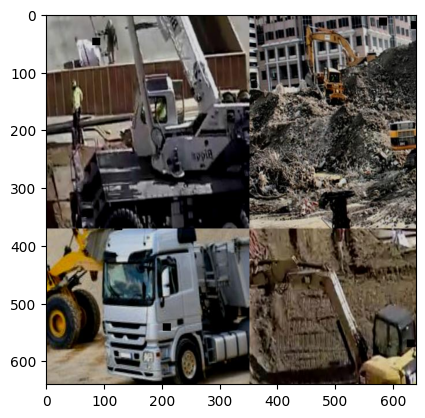

In [10]:
example_image_path = r"C:\Learning\AIPC\YoloV8\data\css-data\train\images\2_jpg.rf.5d1d2457d0de245aa673442ac06891df.jpg"
display_image(example_image_path, print_info = True, hide_axis = False)

In [11]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()


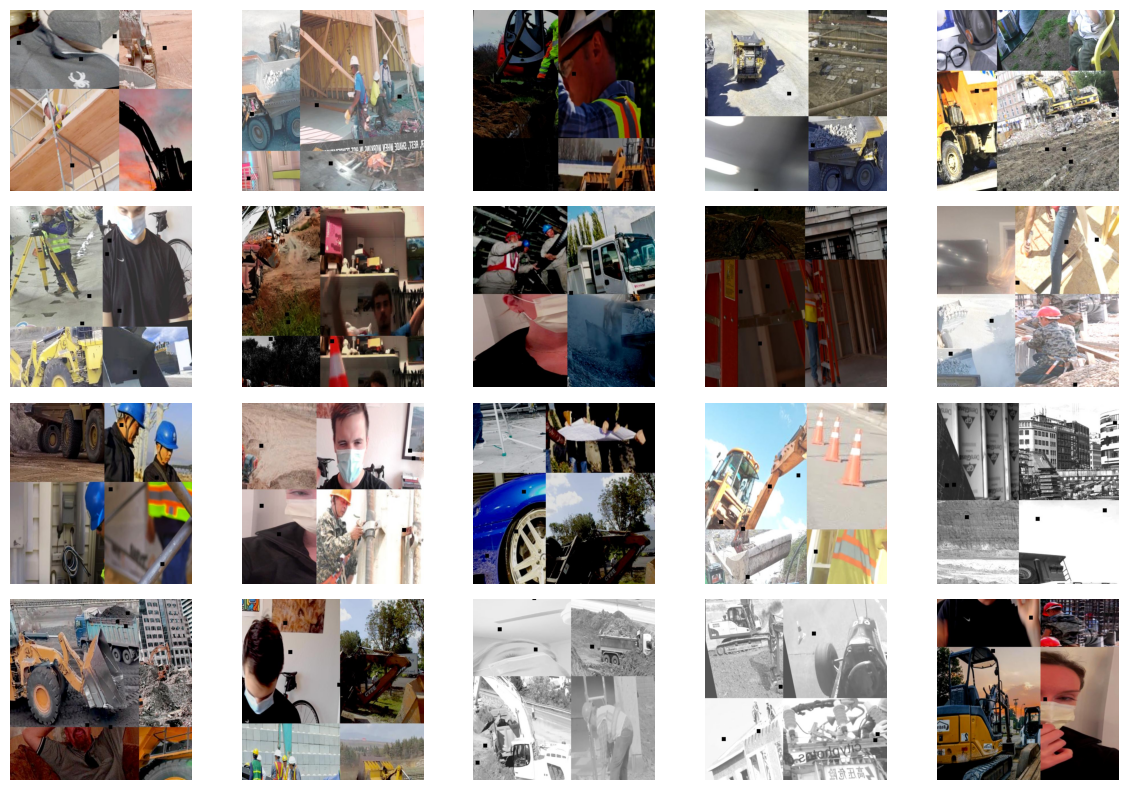

In [12]:
folder_path = CFG.CUSTOM_DATASET_DIR + '\\train\\images\\'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

In [13]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [14]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

Statistics of the dataset

In [ ]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: total: 203 ms
Wall time: 558 ms


,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


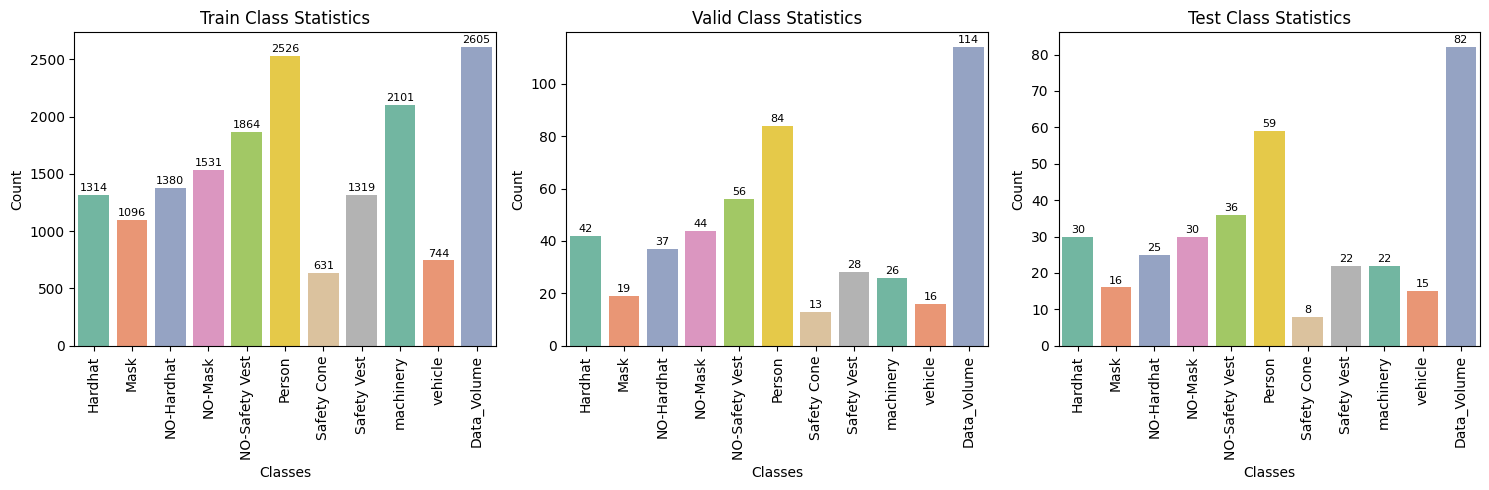

In [16]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()


Image Size

In [17]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)


CPU times: total: 109 ms
Wall time: 786 ms


Performance testing of the base model

In [ ]:
import os
from ultralytics import YOLO

# Make both GPUs visible to PyTorch
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

# Load the YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source=example_image_path,
    conf=0.30,
    device="cuda",
    imgsz=(img_properties['height'], img_properties['width']),
    save=True,
    save_txt=True,
    save_conf=True,
    exist_ok=True,
    nms=True  # Ensure NMS is enabled
)





image 1/1 C:\Learning\AIPC\YoloV8\data\css-data\train\images\2_jpg.rf.5d1d2457d0de245aa673442ac06891df.jpg: 640x640 1 train, 3 trucks, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 84.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
1 label saved to runs\detect\predict\labels


runs/detect/predict/2_jpg.rf.5d1d2457d0de245aa673442ac06891df.jpg
Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



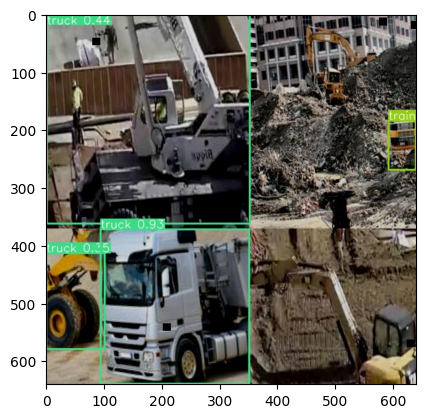

In [20]:
### check predictions with base model
example_image_inference_output = os.path.basename(example_image_path)
display_image(f'runs/detect/predict/{example_image_inference_output}')

Training for custom model

In [21]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8s.pt
Epochs:  50
Batch:  16


In [22]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [23]:
model.train(
    data=os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),
    task='detect',
    imgsz=(img_properties['height'], img_properties['width']),
    epochs=CFG.EPOCHS,
    batch=CFG.BATCH_SIZE,
    optimizer=CFG.OPTIMIZER,
    lr0=CFG.LR,
    lrf=CFG.LR_FACTOR,
    weight_decay=CFG.WEIGHT_DECAY,
    dropout=CFG.DROPOUT,
    fraction=CFG.FRACTION,
    patience=CFG.PATIENCE,
    profile=CFG.PROFILE,
    label_smoothing=CFG.LABEL_SMOOTHING,
    name=f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed=CFG.SEED,
    val=True,
    amp=True,
    exist_ok=True,
    resume=False,
    device=0,  # Use a single GPU
    verbose=False,
    project=None  # Disable W&B logging
)


New https://pypi.org/project/ultralytics/8.3.37 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.29 🚀 Python-3.10.10 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=./data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8s_ppe_css_50_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fals

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: ERROR API key must be 40 characters long, yours was 6
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser her

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:06<00:00, 1.06MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=640'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning C:\Learning\AIPC\YoloV8\data\css-data\train\labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:00<00:00, 2700.88it/s]

train: WARNING ⚠️ C:\Learning\AIPC\YoloV8\data\css-data\train\images\004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ C:\Learning\AIPC\YoloV8\data\css-data\train\images\construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: New cache created: C:\Learning\AIPC\YoloV8\data\css-data\train\labels.cache


val: Scanning C:\Learning\AIPC\YoloV8\data\css-data\valid\labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 1487.60it/s]

val: New cache created: C:\Learning\AIPC\YoloV8\data\css-data\valid\labels.cache


Plotting labels to runs\detect\yolov8s_ppe_css_50_epochs\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\yolov8s_ppe_css_50_epochs
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.99G      1.317      2.025      1.432        461        640: 100%|██████████| 163/163 [00:56<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all        114        697      0.608      0.485       0.52      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.19G      1.203      1.405       1.35        189        640: 100%|██████████| 163/163 [00:50<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        114        697      0.693      0.475      0.528      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.95G      1.185      1.334      1.338        254        640: 100%|██████████| 163/163 [00:49<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]

                   all        114        697      0.659      0.527      0.545      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       4.5G      1.174      1.288      1.327        281        640: 100%|██████████| 163/163 [00:59<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]

                   all        114        697      0.661      0.513      0.539      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.56G      1.144       1.22      1.307        338        640: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]

                   all        114        697      0.733      0.544      0.604      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.32G      1.126      1.163      1.291        213        640: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        114        697      0.745      0.555      0.612      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.16G      1.098      1.113      1.273        192        640: 100%|██████████| 163/163 [01:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]

                   all        114        697      0.774      0.588       0.66      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.71G      1.084      1.085      1.263        214        640: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all        114        697      0.822      0.587      0.678      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.73G      1.061      1.039      1.246        386        640: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        114        697      0.796      0.624      0.681       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.02G      1.037     0.9972      1.235        283        640: 100%|██████████| 163/163 [01:00<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]

                   all        114        697       0.76       0.64       0.69       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.22G      1.029      0.973      1.222        291        640: 100%|██████████| 163/163 [01:04<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.60s/it]

                   all        114        697      0.869      0.586      0.692      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.08G      1.013      0.942      1.209        299        640: 100%|██████████| 163/163 [00:58<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        114        697      0.833      0.641      0.718      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.13G     0.9916     0.9197      1.202        221        640: 100%|██████████| 163/163 [00:55<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:20<00:00,  5.20s/it]

                   all        114        697      0.833      0.653      0.732      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.22G     0.9719     0.8885      1.191        302        640: 100%|██████████| 163/163 [00:58<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        114        697      0.862      0.656      0.732      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.28G     0.9592     0.8812      1.184        322        640: 100%|██████████| 163/163 [01:00<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        114        697      0.833      0.663       0.73      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.21G     0.9507     0.8464      1.171        304        640: 100%|██████████| 163/163 [00:58<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]

                   all        114        697      0.835      0.664      0.735       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       4.7G     0.9445     0.8344      1.167        215        640: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all        114        697      0.844      0.648      0.732      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.59G      0.935     0.8172      1.158        339        640: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all        114        697      0.862      0.681      0.752      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.95G      0.925     0.8014      1.149        286        640: 100%|██████████| 163/163 [00:58<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]

                   all        114        697      0.889      0.681      0.761      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.73G     0.9152     0.7867      1.147        287        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        114        697      0.856      0.698      0.769       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.27G      0.903     0.7788      1.137        338        640: 100%|██████████| 163/163 [00:52<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]

                   all        114        697      0.874      0.685       0.76      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.15G     0.8817     0.7486      1.128        240        640: 100%|██████████| 163/163 [01:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.97s/it]

                   all        114        697       0.84      0.728      0.788      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.35G     0.8804     0.7383      1.129        209        640: 100%|██████████| 163/163 [01:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

                   all        114        697      0.889      0.691      0.785      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.47G     0.8668     0.7239      1.118        269        640: 100%|██████████| 163/163 [01:04<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

                   all        114        697      0.835      0.722      0.779      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.66G      0.862     0.7181      1.116        228        640: 100%|██████████| 163/163 [01:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

                   all        114        697      0.904      0.699      0.793      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.82G     0.8532     0.7085       1.11        394        640: 100%|██████████| 163/163 [01:16<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all        114        697      0.838      0.723      0.795      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.13G     0.8412     0.6934        1.1        282        640: 100%|██████████| 163/163 [01:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all        114        697      0.886      0.706        0.8      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       4.8G     0.8287     0.6723      1.095        209        640: 100%|██████████| 163/163 [00:50<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        114        697      0.872      0.738       0.81      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.56G     0.8234     0.6699      1.092        226        640: 100%|██████████| 163/163 [01:28<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.76s/it]

                   all        114        697      0.917      0.701      0.809      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.25G     0.8155      0.659       1.09        173        640: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]

                   all        114        697      0.876      0.732      0.809      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.84G     0.8071     0.6504      1.081        245        640: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        114        697      0.901       0.73      0.821      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.19G     0.7976     0.6396      1.076        281        640: 100%|██████████| 163/163 [01:00<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        114        697      0.926      0.722      0.814      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.03G     0.7924     0.6329      1.069        298        640: 100%|██████████| 163/163 [01:00<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        114        697      0.891      0.727       0.81      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.85G     0.7829     0.6194      1.063        290        640: 100%|██████████| 163/163 [00:51<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.82it/s]

                   all        114        697      0.905      0.745      0.819      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.12G     0.7868     0.6208      1.069        317        640: 100%|██████████| 163/163 [00:50<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        114        697      0.898      0.765      0.825      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.97G     0.7736     0.6137      1.057        319        640: 100%|██████████| 163/163 [01:10<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all        114        697        0.9      0.743      0.823      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.81G     0.7658     0.6032      1.056        258        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all        114        697      0.896      0.746      0.834      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.77G      0.757     0.5908       1.05        202        640: 100%|██████████| 163/163 [01:05<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.83it/s]

                   all        114        697      0.908      0.747       0.83      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       4.5G      0.741     0.5772      1.044        231        640: 100%|██████████| 163/163 [01:13<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        114        697      0.884      0.773      0.831      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.89G     0.7386     0.5769      1.043        243        640: 100%|██████████| 163/163 [00:55<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        114        697      0.906      0.751      0.834      0.538


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.35G     0.7505     0.5112      1.039        176        640: 100%|██████████| 163/163 [00:51<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

                   all        114        697      0.908      0.732      0.812      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.23G     0.7235     0.4866      1.022        126        640: 100%|██████████| 163/163 [00:52<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        697      0.914      0.742      0.841      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.53G     0.7108     0.4734      1.019        136        640: 100%|██████████| 163/163 [02:33<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        114        697      0.927      0.744      0.843      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.15G     0.7074     0.4663      1.016        186        640: 100%|██████████| 163/163 [01:54<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

                   all        114        697      0.919      0.748      0.839      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.18G     0.6989     0.4655      1.014        219        640: 100%|██████████| 163/163 [00:50<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

                   all        114        697      0.906      0.759      0.841       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       4.4G     0.6835     0.4511      1.001        175        640: 100%|██████████| 163/163 [00:50<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        114        697      0.901      0.772       0.85      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.69G     0.6736     0.4431     0.9952        125        640: 100%|██████████| 163/163 [00:50<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        114        697      0.905      0.781      0.851      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.29G     0.6679     0.4429     0.9945        183        640: 100%|██████████| 163/163 [00:50<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]

                   all        114        697       0.92       0.76      0.848      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.56G     0.6537     0.4317     0.9873        163        640: 100%|██████████| 163/163 [00:50<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        114        697      0.934      0.754      0.848      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.53G     0.6486     0.4272     0.9886        145        640: 100%|██████████| 163/163 [00:50<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]

                   all        114        697      0.908       0.78      0.853       0.57



50 epochs completed in 0.965 hours.
Optimizer stripped from runs\detect\yolov8s_ppe_css_50_epochs\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\yolov8s_ppe_css_50_epochs\weights\best.pt, 22.5MB

Validating runs\detect\yolov8s_ppe_css_50_epochs\weights\best.pt...
Ultralytics YOLOv8.1.29 🚀 Python-3.10.10 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 11129454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


                   all        114        697      0.908      0.782      0.853       0.57
Speed: 5.3ms preprocess, 4.8ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs\detect\yolov8s_ppe_css_50_epochs


lr/pg0,▃▆████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁
lr/pg1,▃▆███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃▆████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▁▂▁▃▄▄▄▅▅▅▅▅▆▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███▇██████
metrics/mAP50-95(B),▁▁▁▂▁▂▃▄▄▄▄▄▅▄▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█████
metrics/precision(B),▁▃▂▂▄▅▆▅▄▇▆▇▆▆▆▇▆▇▆▇▆▇▇▇▇▇█▇▇▇▇█████▇███
metrics/recall(B),▁▁▂▂▃▄▄▅▄▅▅▅▅▆▆▆▇▆▇▆▆▇▆▇▇▇▇█▇▇█▇▇▇▇▇██▇█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001A110A2D120>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

Training results

In [24]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov8s_ppe_css_50_epochs\\confusion_matrix.png',
 './runs/detect/yolov8s_ppe_css_50_epochs\\confusion_matrix_normalized.png',
 './runs/detect/yolov8s_ppe_css_50_epochs\\F1_curve.png',
 './runs/detect/yolov8s_ppe_css_50_epochs\\PR_curve.png',
 './runs/detect/yolov8s_ppe_css_50_epochs\\P_curve.png',
 './runs/detect/yolov8s_ppe_css_50_epochs\\results.png',
 './runs/detect/yolov8s_ppe_css_50_epochs\\R_curve.png',
 './runs/detect/yolov8s_ppe_css_50_epochs\\labels.jpg',
 './runs/detect/yolov8s_ppe_css_50_epochs\\labels_correlogram.jpg']

./runs/detect/yolov8s_ppe_css_50_epochs\F1_curve.png
./runs/detect/yolov8s_ppe_css_50_epochs\F1_curve.png


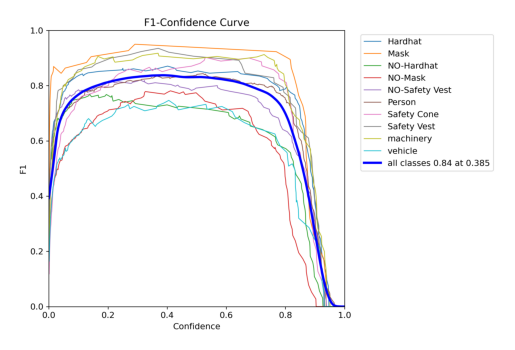



./runs/detect/yolov8s_ppe_css_50_epochs\PR_curve.png
./runs/detect/yolov8s_ppe_css_50_epochs\PR_curve.png


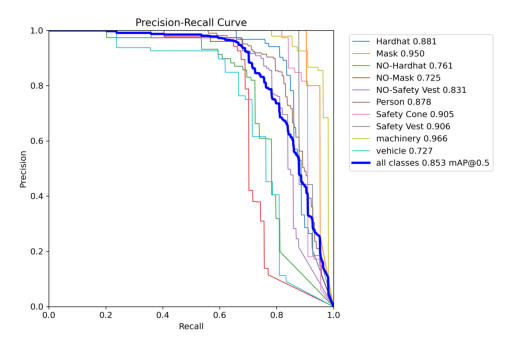



./runs/detect/yolov8s_ppe_css_50_epochs\P_curve.png
./runs/detect/yolov8s_ppe_css_50_epochs\P_curve.png


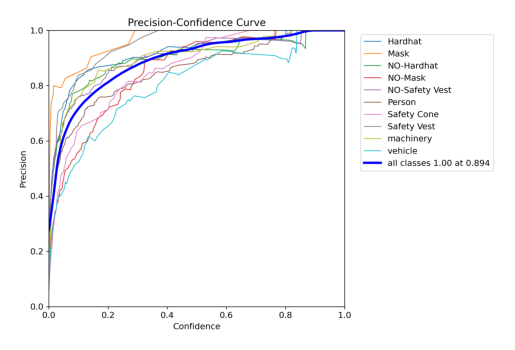



./runs/detect/yolov8s_ppe_css_50_epochs\R_curve.png
./runs/detect/yolov8s_ppe_css_50_epochs\R_curve.png


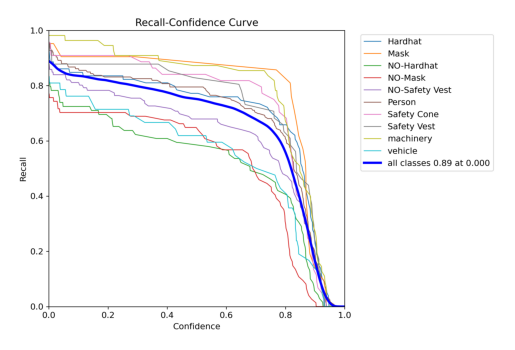



./runs/detect/yolov8s_ppe_css_50_epochs\confusion_matrix.png
./runs/detect/yolov8s_ppe_css_50_epochs\confusion_matrix.png


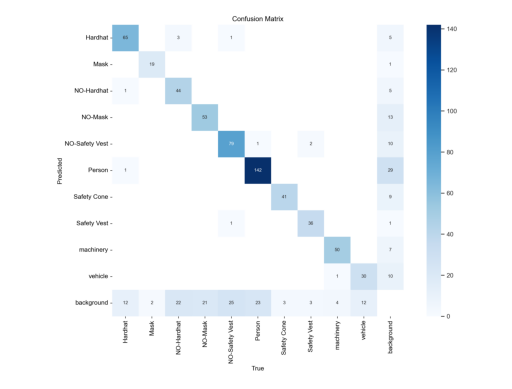



./runs/detect/yolov8s_ppe_css_50_epochs\confusion_matrix_normalized.png
./runs/detect/yolov8s_ppe_css_50_epochs\confusion_matrix_normalized.png


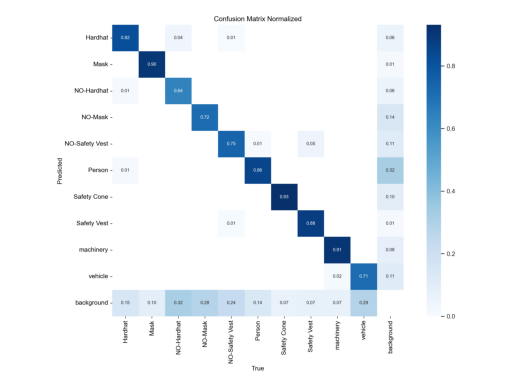



./runs/detect/yolov8s_ppe_css_50_epochs\labels.jpg
./runs/detect/yolov8s_ppe_css_50_epochs\labels.jpg


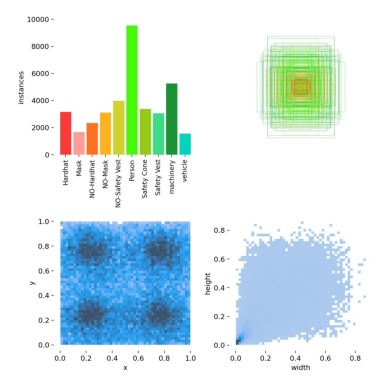



./runs/detect/yolov8s_ppe_css_50_epochs\labels_correlogram.jpg
./runs/detect/yolov8s_ppe_css_50_epochs\labels_correlogram.jpg


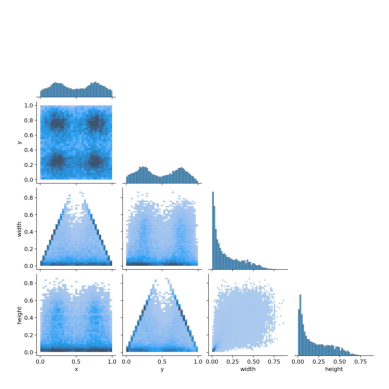



./runs/detect/yolov8s_ppe_css_50_epochs\results.png
./runs/detect/yolov8s_ppe_css_50_epochs\results.png


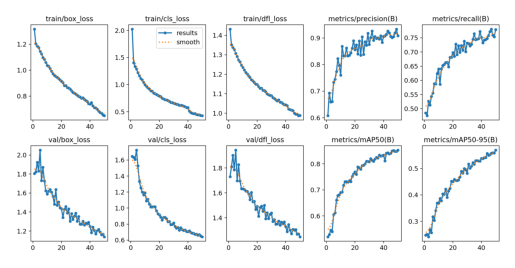

In [25]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

#### Loss function:

YOLO's loss function, which tells the model how wrong its predictions are, has three parts:

#### Box Loss:
    This measures how well the predicted boxes around objects match the actual boxes. It uses a method like Mean Squared Error (MSE) to compare the predicted box's center, width, and height to the real box's dimensions. Think of it like measuring how accurately you've drawn a rectangle around an object.

#### Class Loss (cls):
    This checks if the model correctly identified the type of object in the box (e.g., car, person, dog). It uses a method called categorical cross-entropy, which compares the model's predicted probabilities for each class to the actual class. It penalizes the model for misclassifications.

#### Objectness Loss (dfl - Distribution Focal Loss): 
    This determines if the model correctly predicted whether any object is present in a given area. It assigns an "objectness" score to each box. The loss measures how well these scores match the reality of whether an object is actually there. This helps the model avoid predicting boxes where there are no objects and ensures it finds boxes where there are.

The total loss is just a combination of these three parts, giving the model a complete picture of its errors.

In [26]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.31710,2.02520,1.43230,0.60772,0.48464,0.51964,0.24759,1.8036,1.64550,1.7298,0.000237,0.000237,0.000237
1,2,1.20340,1.40470,1.35040,0.69321,0.47531,0.52803,0.25100,1.8225,1.63360,1.8097,0.000465,0.000465,0.000465
2,3,1.18490,1.33390,1.33770,0.65937,0.52698,0.54490,0.24157,1.9221,1.60810,1.9026,0.000684,0.000684,0.000684
3,4,1.17420,1.28850,1.32730,0.66126,0.51294,0.53923,0.26873,1.8311,1.72400,1.7861,0.000672,0.000672,0.000672
4,5,1.14450,1.21980,1.30720,0.73328,0.54382,0.60444,0.25721,2.0512,1.52760,1.9434,0.000672,0.000672,0.000672
5,6,1.12630,1.16260,1.29090,0.74545,0.55532,0.61185,0.31728,1.7305,1.33350,1.6976,0.000657,0.000657,0.000657
6,7,1.09760,1.11260,1.27330,0.77353,0.58799,0.66047,0.30319,1.8708,1.25290,1.8272,0.000643,0.000643,0.000643
7,8,1.08380,1.08480,1.26340,0.82217,0.58719,0.67812,0.34122,1.7276,1.20030,1.6946,0.000629,0.000629,0.000629
8,9,1.06050,1.03850,1.24620,0.79620,0.62411,0.68119,0.36970,1.6227,1.16360,1.6341,0.000615,0.000615,0.000615
9,10,1.03690,0.99724,1.23450,0.75977,0.64027,0.69028,0.36963,1.5886,1.19080,1.6329,0.000601,0.000601,0.000601


In [27]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.64861 , on epoch:  50 


Best Validation Box loss:  1.1397 , on epoch:  50 


Best Training Cls loss:  0.42718 , on epoch:  50 


Best Validation Cls loss:  0.64196 , on epoch:  50 


Best Training DFL loss:  0.98731 , on epoch:  49 


Best Validation DFL loss:  1.248 , on epoch:  50 



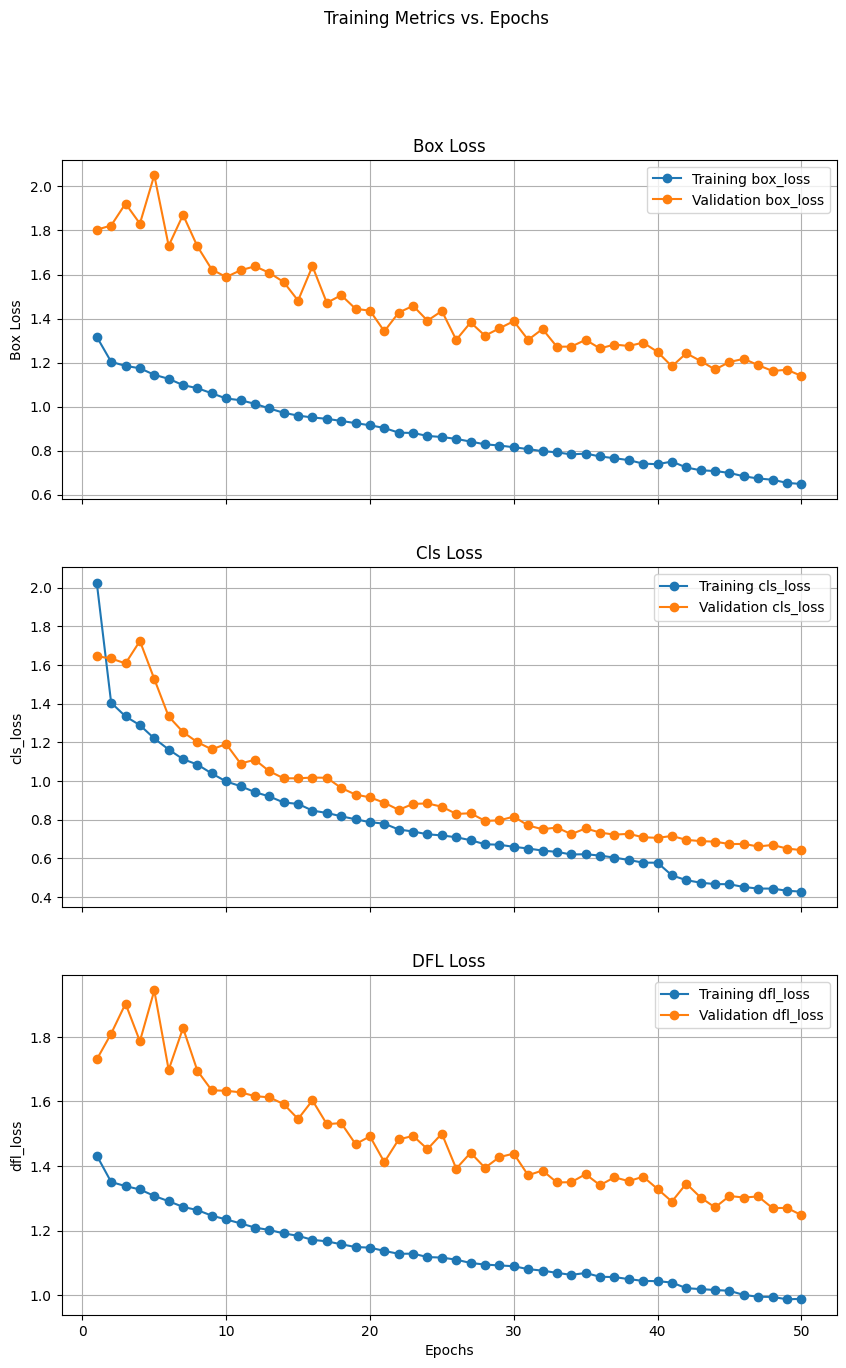

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

In [29]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [30]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov8s_ppe_css_50_epochs\val_batch2_pred.jpg


./runs/detect/yolov8s_ppe_css_50_epochs\val_batch1_labels.jpg
./runs/detect/yolov8s_ppe_css_50_epochs\val_batch1_labels.jpg


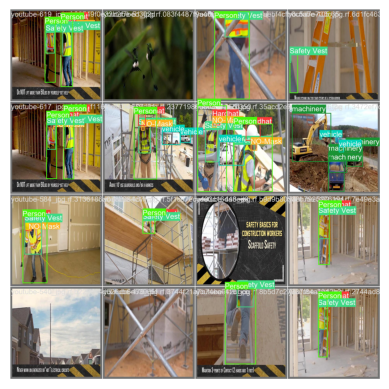

In [31]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

In [32]:
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

Exporting the trained custom model

In [33]:
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.1.29 🚀 Python-3.10.10 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 11129454 parameters, 0 gradients, 28.5 GFLOPs

PyTorch: starting from 'runs\detect\yolov8s_ppe_css_50_epochs\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (21.5 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ---------------------------------------- 14.5/14.5 MB 1.3 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 19.9s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 22.1s, saved as 'runs\detect\yolov8s_ppe_css_50_epochs\weights\best.onnx' (42.7 MB)

Export complete (23.4s)
Results saved to C:\Learning\AIPC\YoloV8\data\runs\detect\yolov8s_ppe_css_50_epochs\weights
Predict:         yolo predict task=det

'runs\\detect\\yolov8s_ppe_css_50_epochs\\weights\\best.onnx'